In [5682]:
import math
import random
import numpy as np
import pathlib as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Dataset control unit

In [5683]:
DATASETS_DIR = "datasets"

TRAIN_PATH = pl.Path(f"{DATASETS_DIR}/train.csv");
TEST_PATH = pl.Path(f"{DATASETS_DIR}/test_features.csv");
SUBMISSION_PATH = pl.Path(f"{DATASETS_DIR}/sample_submission.csv");

## Analysis control unit

In [5684]:
USE_PAIRPLOTS = False
USE_BARPLOTS = False
USE_PCA = True

In [5685]:
df = pd.read_csv(TRAIN_PATH)

### Analysing data from the available dataset

In [5686]:
df

,Sex,Length,Diameter,Height,weight_1,weight_2,weight_3,weight_4,target
0,M,0.725,0.550,0.200,1.5100,0.8735,0.4265,0.5085,9
1,F,0.415,0.340,0.130,0.3675,0.1460,0.0885,0.1200,10
2,M,0.705,0.555,0.215,2.1410,1.0465,0.3830,0.5280,11
3,I,0.375,0.290,0.095,0.2875,0.1230,0.0605,0.0800,6
4,F,0.680,0.500,0.185,1.7410,0.7665,0.3255,0.4685,12
...,...,...,...,...,...,...,...,...,...
3131,F,0.575,0.480,0.165,1.0780,0.5110,0.2095,0.3060,9
3132,M,0.585,0.455,0.125,1.0270,0.3910,0.2120,0.2500,17
3133,I,0.395,0.270,0.100,0.2985,0.1445,0.0610,0.0820,5
3134,M,0.415,0.305,0.100,0.3250,0.1560,0.0505,0.0910,6


In [5687]:
df.describe()

,Length,Diameter,Height,weight_1,weight_2,weight_3,weight_4,target
count,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000,3136.000000
mean,0.524141,0.407868,0.139115,0.829300,0.359130,0.180738,0.239251,9.948023
std,0.120807,0.099984,0.039111,0.492789,0.222860,0.110205,0.139756,3.290532
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.348750,0.115000,0.440500,0.184375,0.092875,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.801000,0.336000,0.171000,0.234500,9.000000
75%,0.615000,0.480000,0.165000,1.156500,0.503625,0.254000,0.330000,11.000000
max,0.815000,0.650000,0.515000,2.825500,1.488000,0.760000,0.897000,29.000000


In [5688]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3136 entries, 0 to 3135
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex       3136 non-null   object 
 1   Length    3136 non-null   float64
 2   Diameter  3136 non-null   float64
 3   Height    3136 non-null   float64
 4   weight_1  3136 non-null   float64
 5   weight_2  3136 non-null   float64
 6   weight_3  3136 non-null   float64
 7   weight_4  3136 non-null   float64
 8   target    3136 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 220.6+ KB


In [5689]:
if USE_PAIRPLOTS:
    sns.set()
    sns.pairplot(df[['Length', 'Height', 'Diameter', 'weight_1', 'weight_2', 'weight_3', 'weight_4']], diag_kind="kde")

In [5690]:
if USE_BARPLOTS:
    sns.barplot(x=df['target'], y=df['Sex']);

In [5691]:
if USE_BARPLOTS:
    sns.barplot(x=df['target'], y=df['weight_1']);

## Data control unit

In [5692]:
USE_FEATURE_DROP = False
USE_FEATURE_ENGINEERING = False
USE_FEATURE_SCALING = False
USE_OUTLIER_DETECTION = True
USE_FEATURE_POLYNOMIAL = False

### Data preprocessing

In [5693]:
if USE_FEATURE_DROP:
    df.drop(["Sex"], inplace=True, axis=1)
else:
    df = pd.get_dummies(df, columns=["Sex"])

### Feature engineering

In [5694]:
if USE_FEATURE_ENGINEERING:
    df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
    df.drop(['Length', 'Diameter', 'Height'], axis=1, inplace=True)
    df['Weight'] = df['weight_1'] * df['weight_2'] * df['weight_3'] * df['weight_4']
    df.drop(['weight_1', 'weight_2', 'weight_3', 'weight_4'], axis=1, inplace=True)

### Data normalisation and filtration

In [5695]:
if USE_FEATURE_SCALING:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    if USE_FEATURE_ENGINEERING:
        scaling_columns = ["Volume", "Weight"]
    else:
        scaling_columns = ['Length', 'Diameter', 'Height', 'weight_1', 'weight_2', 'weight_3', 'weight_4']
    df[scaling_columns] = scaler.fit_transform(df[scaling_columns])

In [5696]:
if USE_OUTLIER_DETECTION:
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [5697]:
if USE_FEATURE_POLYNOMIAL:
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=2, include_bias=False)
    if USE_FEATURE_ENGINEERING:
        polynomial_columns = ["Volume", "Weight"]
    else:
        polynomial_columns = ['Length', 'Diameter', 'Height', 'weight_1', 'weight_2', 'weight_3', 'weight_4']
    
    poly_np = poly.fit_transform(df[polynomial_columns])
    poly_df = pd.DataFrame(poly_np, columns=[str(i) for i, _ in enumerate(poly_np[0])])
    
    df.drop(polynomial_columns, axis=1, inplace=True)
    
    df = df.reset_index(drop=True)
    poly_df = poly_df.reset_index(drop=True)
    
    df = df.join(poly_df)

### Data visualisation after pipeline

In [5698]:
if USE_PAIRPLOTS:
    sns.set()
    if USE_FEATURE_DROP:
        sns.pairplot(df[df.columns.difference(['target'])], diag_kind="kde")
    else:
        sns.pairplot(df[df.columns.difference(['target', 'Sex_M', 'Sex_I', 'Sex_F'])], diag_kind="kde")

In [5699]:
if USE_BARPLOTS:
    if USE_FEATURE_ENGINEERING:
        sns.barplot(x=df['target'], y=df['Volume']);

In [5700]:
if USE_BARPLOTS:
    if USE_FEATURE_ENGINEERING:
        sns.barplot(x=df['target'], y=df['Weight']);

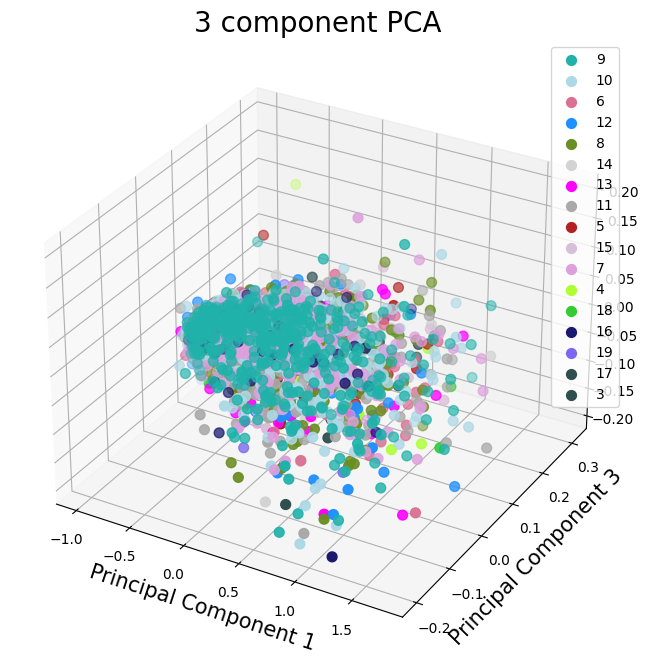

In [5701]:
if USE_PCA:
    from sklearn.decomposition import PCA
    from matplotlib import colors
    pca = PCA(n_components=3)
    if USE_FEATURE_DROP:
        pca_components_df = pca.fit_transform(df[df.columns.difference(['target'])])
    else:
        pca_components_df = pca.fit_transform(df[df.columns.difference(['target', 'Sex_M', 'Sex_I', 'Sex_F'])])
    pca_df = pd.DataFrame(data=pca_components_df, columns=['c-1', 'c-2', 'c-3'])
    pca_df['target'] = df['target']
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1, projection='3d') 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_ylabel('Principal Component 3', fontsize = 15)
    ax.set_title('3 component PCA', fontsize = 20)
    targets = df['target'].unique()
    colors = random.sample(list(colors.cnames.values()), len(targets))
    for target, color in zip(targets, colors):
        target_index = pca_df.loc[pca_df['target'] == target].index
        ax.scatter(pca_df.iloc[target_index]['c-1'],
                   pca_df.iloc[target_index]['c-2'],
                   pca_df.iloc[target_index]['c-3'],
                   c = color,
                   s = 50)
    ax.legend(targets)
    ax.grid()

### Building model

In [5702]:
USE_MODEL_SELECTION = False
USE_MODEL_LINEAR_REGRESSION = False
USE_MODEL_KNN = False
USE_ENSEMBLE = True
USE_RMSE_METRIC = True

verbose = True

In [5703]:
if USE_MODEL_SELECTION:
    from sklearn.linear_model import LogisticRegression, LinearRegression
    from sklearn.svm import SVC
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB

    models = [
        GaussianNB(),
        KNeighborsClassifier(n_neighbors=40),
        SVC(kernel='poly', class_weight='balanced'), 
        SVC(kernel='linear', class_weight='balanced'), 
        LogisticRegression(random_state=42, class_weight='balanced'), 
        LinearRegression(),
        DecisionTreeClassifier()
    ]

    experiments = 15
    avg_accuracies = []
    avg_rmses      = []

    for model in models:
        print("-"*40)
        print(f"Analysing {type(model).__name__}")

        avg_rmse = 0
        avg_accuracy = 0

        for experiment in range(experiments):        
            train_df, test_df = train_test_split(df, test_size=0.2, random_state=round(random.random() * 100))
            y_train, X_train = train_df['target'], train_df.drop('target', axis=1)
            y_test, X_test = test_df['target'], test_df.drop('target', axis=1)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            rmse = mean_squared_error(y_test, y_pred, squared=False)
            avg_rmse += rmse
            if verbose:
                print(f"{experiment + 1}: RMSE={rmse}")

            accuracy = model.score(X_test, y_test)
            avg_accuracy += accuracy
            if verbose:
                print(f"{experiment + 1}: Accuracy={accuracy * 100}%")

        avg_rmse /= experiments
        avg_rmses.append(avg_rmse)
        print(f"Average RMSE: {avg_rmse}")

        avg_accuracy /= experiments
        avg_accuracies.append(avg_accuracy)
        print(f"Average accuracy: {avg_accuracy * 100}%")

    best_model = None 
    best_rmse, best_accuracy = +math.inf, -math.inf

    for model, avg_rmse, avg_accuracy in zip(models, avg_rmses, avg_accuracies):
        if USE_RMSE_METRIC:
            if best_rmse > avg_rmse:
                best_rmse = avg_rmse
                best_accuracy = avg_accuracy
                best_model = model
        else:
            if best_accuracy < avg_accuracy:
                best_rmse = avg_rmse
                best_accuracy = avg_accuracy
                best_model = model

    print("-"*40)
    print(f"Minimum RMSE: {best_rmse}")
    print(f"Maximum accuracy: {best_accuracy * 100}%")

In [5704]:
if USE_ENSEMBLE:
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn import metrics
    
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=round(random.random() * 100))
    y_train, X_train = train_df['target'], train_df.drop('target', axis=1)
    y_test, X_test = test_df['target'], test_df.drop('target', axis=1)
    
    USE_SEARCH_PARAMS = True
    
    if USE_SEARCH_PARAMS:
        param_grid = {
            'n_estimators': np.linspace(50, 100, 3, dtype = int),
            'max_depth': [100, 125, 150],
        }

        best_estimator = RandomForestClassifier(criterion='entropy', bootstrap=True)
        best_model = GridSearchCV(estimator=best_estimator, 
                                  param_grid=param_grid, 
                                  cv=5, 
                                  n_jobs=8, 
                                  verbose=2)
    else:
        best_model = RandomForestClassifier(n_estimators=100, random_state=0)
        
        if verbose:
            feature_scores = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            print(feature_scores)
    
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    if verbose:
        print(f"RMSE={rmse}")

    accuracy = metrics.accuracy_score(y_test, y_pred)
    if verbose:
        print(f"Accuracy={accuracy * 100}%")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
RMSE=2.2618342202148902
Accuracy=26.490066225165563%


In [5705]:
if USE_MODEL_KNN:
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=round(random.random() * 100))
    y_train, X_train = train_df['target'], train_df.drop('target', axis=1)
    y_test, X_test = test_df['target'], test_df.drop('target', axis=1)

    best_k, best_model = 0, None
    best_rmse, best_accuracy = +math.inf, -math.inf

    for k in range(200):
        model = KNeighborsClassifier(n_neighbors=k + 1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        if verbose:
            print(f"k={k}: RMSE={rmse}")

        accuracy = model.score(X_test, y_test)
        if verbose:
            print(f"k={k}: Accuracy={accuracy * 100}%")

        if USE_RMSE_METRIC:
            if best_rmse > rmse:
                best_rmse = rmse
                best_accuracy = accuracy
                best_k = k
                best_model = model
        else:
            if best_accuracy < accuracy:
                best_rmse = rmse
                best_accuracy = accuracy
                best_k = k
                best_model = model
        
    print(f"Best k for KNeighborsClassifier: {best_k}")
    print(f"Best RMSE: {best_rmse}")
    print(f"Best accuracy: {best_accuracy}")

In [5706]:
if USE_MODEL_LINEAR_REGRESSION:
    experiments = 100
    
    best_model = None
    best_rmse, best_accuracy = +math.inf, -math.inf

    for experiment in range(experiments):
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=round(random.random() * 100))
        y_train, X_train = train_df['target'], train_df.drop('target', axis=1)
        y_test, X_test = test_df['target'], test_df.drop('target', axis=1)
        
        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred = [round(y_sample) for y_sample in y_pred]

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        if verbose:
            print(f"{experiment + 1}: RMSE={rmse}")

        accuracy = model.score(X_test, y_test)
        if verbose:
            print(f"{experiment + 1}: Accuracy={accuracy * 100}%")

        if USE_RMSE_METRIC:
            if best_rmse > rmse:
                best_rmse = rmse
                best_accuracy = accuracy
                best_k = k
                best_model = model
        else:
            if best_accuracy < accuracy:
                best_rmse = rmse
                best_accuracy = accuracy
                best_k = k
                best_model = model
        
    print(f"Best RMSE: {best_rmse}")
    print(f"Best accuracy: {best_accuracy}")

In [5707]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names = df["target"].unique() # name of classes

Text(0.5, 427.9555555555555, 'Predicted label')

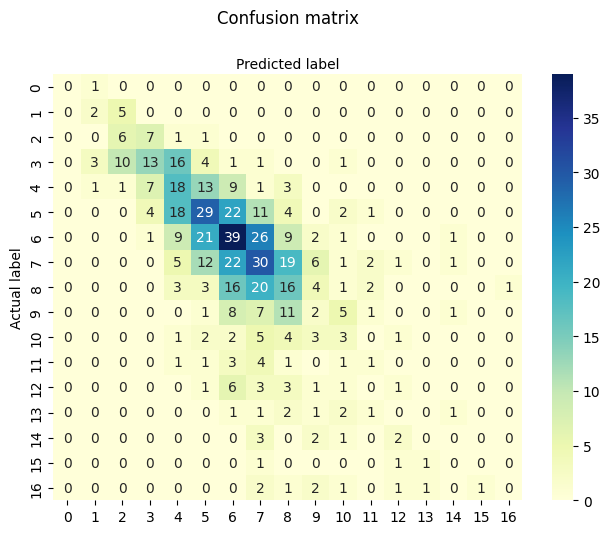

In [5708]:
# configure heatmap
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [5709]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.29      0.29      0.29         7
           5       0.27      0.40      0.32        15
           6       0.41      0.27      0.32        49
           7       0.25      0.34      0.29        53
           8       0.33      0.32      0.32        91
           9       0.30      0.36      0.33       109
          10       0.26      0.30      0.28        99
          11       0.22      0.24      0.23        66
          12       0.09      0.06      0.07        36
          13       0.15      0.14      0.15        21
          14       0.12      0.08      0.10        12
          15       0.14      0.06      0.09        16
          16       0.00      0.00      0.00         9
          17       0.00      0.00      0.00         8
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         9

    accuracy              

/Users/danorel/Workspace/Education/University/KMA/Labs/ML/kaggle-humanity/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danorel/Workspace/Education/University/KMA/Labs/ML/kaggle-humanity/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/danorel/Workspace/Education/University/KMA/Labs/ML/kaggle-humanity/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels w

### Trying model with test data

In [5710]:
df = pd.read_csv(TEST_PATH)

In [5711]:
if USE_FEATURE_DROP:
    df.drop(["Sex"], inplace=True, axis=1)
else:
    df = pd.get_dummies(df, columns=["Sex"])

In [5712]:
if USE_FEATURE_ENGINEERING:
    df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
    df.drop(['Length', 'Diameter', 'Height'], axis=1, inplace=True)
    df['Weight'] = df['weight_1'] * df['weight_2'] * df['weight_3'] * df['weight_4']
    df.drop(['weight_1', 'weight_2', 'weight_3', 'weight_4'], axis=1, inplace=True)

In [5713]:
if USE_FEATURE_SCALING:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    if USE_FEATURE_ENGINEERING:
        scaling_columns = ["Volume", "Weight"]
    else:
        scaling_columns = ['Length', 'Diameter', 'Height', 'weight_1', 'weight_2', 'weight_3', 'weight_4']
    df[scaling_columns] = scaler.fit_transform(df[scaling_columns])

In [5714]:
if USE_FEATURE_POLYNOMIAL:
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=2, include_bias=False)
    if USE_FEATURE_ENGINEERING:
        polynomial_columns = ["Volume", "Weight"]
    else:
        polynomial_columns = ['Length', 'Diameter', 'Height', 'weight_1', 'weight_2', 'weight_3', 'weight_4']
    
    poly_np = poly.fit_transform(df[polynomial_columns])
    poly_df = pd.DataFrame(poly_np, columns=[str(i) for i, _ in enumerate(poly_np[0])])
    
    df.drop(polynomial_columns, axis=1, inplace=True)
    
    df = df.reset_index(drop=True)
    poly_df = poly_df.reset_index(drop=True)
    
    df = df.join(poly_df)

In [5715]:
X_output = df
y_output = best_model.predict(X_output)

### Publishing test output to sample submission file

In [5716]:
df = pd.read_csv(SUBMISSION_PATH)
df['target'] = y_output

In [5717]:
df.to_csv(SUBMISSION_PATH)